In [6]:
import time
import torch
import math
import pandas as pd
import numpy as np
import arviz as az
import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')


from torch import nn, Tensor

# flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath, GeodesicProbPath
from flow_matching.solver import Solver, ODESolver, RiemannianODESolver
from flow_matching.utils import ModelWrapper
import math
import torch
from torch.utils.data import Dataset, DataLoader
from sbmfi.priors.mog import MixtureOfGaussians

# visualization
import matplotlib.pyplot as plt

from matplotlib import cm

from PolyRound.api import Polytope
from sbmfi.inference.manifolds import BallManifold, Manifold, ConvexPolytopeManifold
from sbmfi.core.coordinater import *
from sbmfi.core.linalg import LinAlg
from sbmfi.inference.polytope_plotter import plot_dataframes
from sbmfi.inference.continuous_flows import *

In [7]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.set_default_dtype(torch.float)
torch.manual_seed(42)

Using gpu


In [8]:
fcm, v_representation, pol_volume = pickle.load(open('spiro_flux_coordinate_mapper.p', 'rb'))
psm = fcm.sampler
K = psm.dimensionality

### Prepare all the data

In [9]:
data = az.from_netcdf('mog_polytope_105k_samples.nc')
mog_rounded = torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T
mog_target = MixtureOfGaussians(
    means=torch.as_tensor(data.attrs['mog_means'], dtype=torch.float), 
    covariances=torch.as_tensor(data.attrs['mog_covs'], dtype=torch.float),
    weights=torch.as_tensor(data.attrs['mog_weights'], dtype=torch.float),
    log_Z=np.log(data.attrs['mog_Z']),
)
means_df = pd.DataFrame(
    np.hstack([data.attrs['mog_means'], data.attrs['mog_weights'][:, None]]), 
    columns=psm.rounded_id.append(pd.Index(['weights']))
)
mog_Z = data.attrs['mog_Z']
del data

In [10]:
data = az.from_netcdf('unif_polytope_125k_samples.nc')
unif_rounded =  torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T
del data

### Training function

In [11]:
def train_affine(model, optimizer, noise_dataloader, target_dataloader, losses):
    n_steps = n_epochs * len(noise_dataloader)
    pbar = tqdm(total=n_steps, ncols=120, position=0)
    try:
        for epoch in range(n_epochs):
            # use fixed data-set
            noise_iter = iter(noise_dataloader)
            target_iter = iter(target_dataloader)
            
            for i in range(len(noise_dataloader)): 
                optimizer.zero_grad() 
    
                target_chunk = next(target_iter, None)[0]
                noise_chunk = next(noise_iter, None)[0]
        
                t = torch.rand(noise_chunk.shape[0]).to(device) 
    
                # sample probability path
                path_sample = path.sample(t=t, x_0=noise_chunk, x_1=target_chunk)
            
                # flow matching l2 loss
                loss = torch.pow( model(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
            
                # # optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                else:
                    raise ValueError(f'loss: {loss}')
        
                loss_ = loss.item()
                losses.append(loss_)
                pbar.update()
                pbar.set_postfix(loss=round(loss_, 4))
            if (scheduler is not None):
                scheduler.step()            
    except KeyboardInterrupt:
        pass
    except Exception as e:
        raise e
    finally:
        pbar.close()
        return pbar.last_print_t - pbar.start_t

### Affine flow

In [148]:
# training arguments
lr = 1e-3
n_epochs = 35
batch_size = 1024*8
hidden_dim = 512

# velocity field model init
aff_model = MLP(input_dim=mog_rounded.shape[-1], time_dim=1, hidden_dim=hidden_dim).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optimizer = torch.optim.Adam(aff_model.parameters(), lr=lr) 
scheduler = None

test_size = 20000

noise_dataset = torch.utils.data.TensorDataset(unif_rounded.to(dtype=torch.float, device=device))
test_dataset, noise_dataset = torch.utils.data.random_split(noise_dataset, [test_size, len(noise_dataset) - test_size])
noise_dataloader = torch.utils.data.DataLoader(noise_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

target_dataset = torch.utils.data.TensorDataset(mog_rounded.to(dtype=torch.float, device=device))
target_dataloader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

train_time_total = 0.0
losses = []

In [149]:
train_time = train_affine(aff_model, optimizer, noise_dataloader, target_dataloader, losses)
train_time_total += train_time
torch.save(aff_model.state_dict(), "aff_model.pt")
pickle.dump((losses, train_time_total), open('aff_losses.p', 'wb'))
aff_model.load_state_dict(torch.load("aff_model.pt"))
losses = pickle.load(open('aff_losses.p', 'rb'))

C:\Users\diede\AppData\Local\Temp\ipykernel_15480\2670851208.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aff_model.load_state_dict(torch.load("aff_model.pt"))


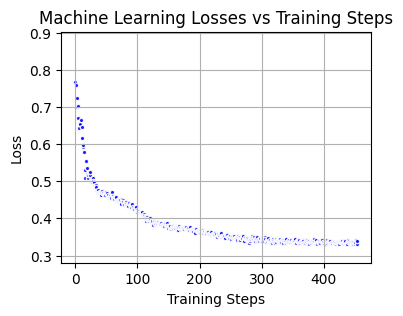

In [150]:
fig = plot_losses_vs_steps(losses)
plt.show()

In [151]:
wrapped_vf = WrappedModel(aff_model)

x_init = test_dataset[:][0].to(dtype=torch.float, device=device)
solver = ODESolver(velocity_model=wrapped_vf)

In [152]:
log_pol_vol = np.log(pol_volume)
def log_p_pol(values):
    return torch.full(values.shape[:-1], -log_pol_vol, dtype=values.dtype, device=values.device)

In [153]:
t_sample_start = time.time()
sol, log_det = sample_and_div(
    ode_solver=solver,
    x_init=x_init,
    step_size=0.05,
    method= "midpoint",
    return_intermediates = False,
    return_div= True,
    exact_divergence=True,
)
t_sample_elapsed = time.time() - t_sample_start

log_q0 = log_p_pol(x_init)
log_q = log_q0 - log_det
soll = sol.to(device='cpu', dtype=torch.double)


In [154]:
t_only_sample = time.time()
_ = solver.sample(
    x_init=x_init,
    method='midpoint',
    step_size=0.05,
    return_intermediates=False,
)  # sample from the model
t_only_sample_elapsed = time.time() - t_only_sample

# uncomment the lines below to check that the forward and reverse divergence are equal.
# _, log_q2 = solver.compute_likelihood(
#     x_1=sol2,
#     method='midpoint',
#     step_size=0.05, 
#     exact_divergence=True,
#     log_p0=log_p_pol,
#     return_intermediates=True
# )
# # log_q2 is almost equal to log_q from the cell above!

In [155]:
n_test = x_init.shape[0]

in_pol = ((psm._G @ soll.T) < psm._h).all(0)
in_pol_sum = in_pol.sum()
filtered_soll = soll[in_pol]

log_p = mog_target.log_prob(filtered_soll)
log_qq = log_q.to('cpu')[:, in_pol]

ws = torch.exp(log_p - log_qq)
KL_Z = ws.mean()
ln_KL = (log_p - log_qq).mean() + np.log(KL_Z)
KL = torch.exp(ln_KL)
ESS = ws.sum()**2 / (ws**2).sum()

print(f'ESS: {round(ESS.item() / n_test, 3)}, KL div.: {KL:.3e}, in pol: {1.0 - (in_pol_sum.item() / n_test)},' \
    f'training time: {train_time_total}, sampling time: {t_sample_elapsed}, only sample time {t_only_sample_elapsed}')

ESS: 0.801, KL div.: 8.374e-01, in pol: 0.058050000000000046,training time: 0.0, sampling time: 74.67183804512024, only sample time 3.841782569885254


In [75]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=v_representation,
    samples=pd.DataFrame(soll.numpy(), columns=psm.rounded_id),
    n_sample_cdf=10000,
    points=means_df,
    x_col='R_h_out', 
    y_col='R_biomass',
    x_label='R_h_out', 
    y_label='R_biomass',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
# plt.show()

In [76]:
plt.savefig(
    'affine_flow.svg', transparent=None, dpi='figure', format='svg',
    metadata=None, bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto', backend=None,
)

### Higher dimensions

In [4]:
data = az.from_netcdf('Kmog_polytope_105k_samples.nc')
A_cols = [v[2:] for v in data.posterior.theta_id.values]
Kpol = Polytope(
    A=pd.DataFrame(data.attrs['A'], columns=A_cols),
    b=pd.Series(data.attrs['b']),
)
Kpsm = PolytopeSamplingModel(Kpol, linalg=LinAlg(backend='torch'))
Kmeans_df = pd.DataFrame(
    np.hstack([data.attrs['mog_means'], data.attrs['mog_weights'][:, None]]), 
    columns=Kpsm.rounded_id.append(pd.Index(['weights']))
)
Kmog_target = MixtureOfGaussians(
    means=torch.as_tensor(data.attrs['mog_means'], dtype=torch.float), 
    covariances=torch.as_tensor(data.attrs['mog_covs'], dtype=torch.float),
    weights=torch.as_tensor(data.attrs['mog_weights'], dtype=torch.float),
    log_Z=np.log(data.attrs['mog_Z']),
)
Kmog_rounded =  torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values, device=device, dtype=torch.float
).T
# del data

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-27


In [6]:
data = az.from_netcdf('Kunif_polytope_125k_samples.nc')
Kunif_rounded =  torch.as_tensor(
    az.extract(data, combined=True, var_names='theta', keep_dataset=False, rng=2).values
).T
del data

In [7]:
lr = 1e-3
n_epochs = 35
batch_size = 1024*8
hidden_dim = 1024
test_size = 20000

# velocity field model init
Kaff_model = MLP(input_dim=Kunif_rounded.shape[-1], time_dim=1, hidden_dim=hidden_dim, hidden_layers=6).to(device) 

# instantiate an affine path object
path = AffineProbPath(scheduler=CondOTScheduler())

# init optimizer
optimizer = torch.optim.Adam(Kaff_model.parameters(), lr=lr) 
scheduler = None

target_dataset = torch.utils.data.TensorDataset(Kmog_rounded.to(dtype=torch.float, device=device))
target_dataloader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

noise_dataset = torch.utils.data.TensorDataset(Kunif_rounded.to(dtype=torch.float, device=device))
test_dataset, noise_dataset = torch.utils.data.random_split(noise_dataset, [test_size, len(noise_dataset) - test_size])
noise_dataloader = torch.utils.data.DataLoader(noise_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

train_time_total = 0.0
losses = []

In [8]:
train_time = train_affine(Kaff_model, optimizer, noise_dataloader, target_dataloader, losses)
train_time_total += train_time

torch.save(Kaff_model.state_dict(), "Kaff_model.pt")
pickle.dump((losses, train_time_total), open('Kaff_model_losses.p', 'wb'))

Kaff_model.load_state_dict(torch.load("Kaff_model.pt"))
losses, train_time_total = pickle.load(open('Kaff_model_losses.p', 'rb'))

C:\Users\diede\AppData\Local\Temp\ipykernel_13996\3887129052.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Kaff_model.load_state_dict(torch.load("Kaff_model.pt"))


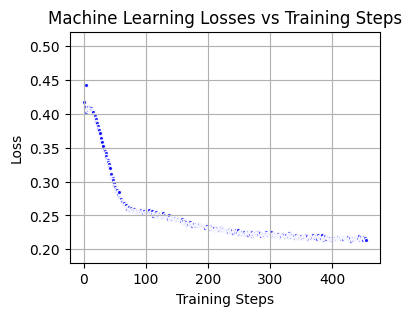

In [9]:
fig = plot_losses_vs_steps(losses)
plt.show()

In [10]:
wrapped_vf = WrappedModel(Kaff_model)

step_size = torch.Tensor([0.05]).to(device=device, dtype=torch.float)

x_init = test_dataset[:][0].to(dtype=torch.float, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class

In [17]:
sols = []
log_dets = []
test_loader = torch.utils.data.DataLoader(x_init, batch_size=1500)

t_sample_start = time.time()

for i, batch in enumerate(test_loader):
    print(i)
    sol, log_det = sample_and_div(
        ode_solver=solver,
        x_init=batch,
        step_size=0.05,
        method= "midpoint",
        return_intermediates = False,
        return_div= True,
        exact_divergence=True,
    )
    sols.append(sol.detach())
    log_dets.append(log_det.detach())

t_sample_elapsed = time.time() - t_sample_start

pickle.dump((torch.cat(sols).to('cpu'), torch.cat(log_dets, 1).to('cpu'), t_sample_elapsed), open('Kflow_sols_log_dets2.p', 'wb'))

In [11]:
t_only_sample = time.time()
_ = solver.sample(
    x_init=x_init,
    method='midpoint',
    step_size=0.05,
    return_intermediates=False,
)  # sample from the model
t_only_sample_elapsed = time.time() - t_only_sample

In [12]:
sol, log_det, t_sample_elapsed = pickle.load(open('Kflow_sols_log_dets.p', 'rb'))
sol = sol.to(dtype=torch.double)
log_det = log_det.to(dtype=torch.double)

In [13]:
log_pol_vol = -np.log(2**Kpsm.dimensionality)
def log_p_pol(values):
    return torch.full(values.shape[:-1], log_pol_vol, dtype=values.dtype, device=values.device)

In [14]:
log_q0 = log_p_pol(x_init.to(device='cpu'))
log_q = log_q0 - log_det
soll = sol.to(device='cpu', dtype=torch.double)

In [15]:
n_test = x_init.shape[0]

in_pol = ((Kpsm._G @ soll.T) < Kpsm._h).all(0)
in_pol_sum = in_pol.sum()
filtered_soll = soll[in_pol]

log_p = Kmog_target.log_prob(filtered_soll)
log_qq = log_q.to('cpu')[:, in_pol]

ws = torch.exp(log_p - log_qq)
KL_Z = ws.mean()
ln_KL = (log_p - log_qq).mean() + np.log(KL_Z)
KL = torch.exp(ln_KL)
ESS = ws.sum()**2 / (ws**2).sum()

print(f'ESS: {round(ESS.item() / n_test, 3)}, KL div.: {KL:.3e}, in pol: {1.0 - (in_pol_sum.item() / n_test)},' \
    f'training time: {train_time_total}, sampling time: {t_sample_elapsed}, only sample time {t_only_sample_elapsed}')

ESS: 0.198, KL div.: 8.236e-02, in pol: 0.12495,training time: 302.3912925720215, sampling time: 991.6410048007965, only sample time 11.42766547203064


In [51]:
import itertools
Kv_representation = pd.DataFrame(np.array(list(itertools.product([-1, 1], repeat=20))), columns=Kpsm.rounded_id)

In [56]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=Kv_representation,
    samples=pd.DataFrame(sol, columns=Kpsm.rounded_id),
    n_sample_cdf=1000,
    points=Kmeans_df,
    x_col='R_fki', 
    y_col='R_bfn',
    x_label='R_fki', 
    y_label='R_bfn',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
    yticker=0.5,
    xticker=0.5,
)
# plt.show()

In [57]:
plt.savefig(
    'Kaffine_flow.svg', transparent=None, dpi='figure', format='svg',
    metadata=None, bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto', backend=None,
)

### Riemannian flows

In [6]:
def train_riemann(model, optimizer, dataloader, losses):
    n_steps = n_epochs * len(dataloader)
    pbar = tqdm(total=n_steps, ncols=120, position=0)
    try:
        for epoch in range(n_epochs):
            # use fixed data-set
            for i, target_chunk in enumerate(dataloader): 
                optimizer.zero_grad() 

                target_chunk = target_chunk[0]
                noise_chunk = ball_noise.sample(target_chunk.shape[0])
    
                t = torch.rand(target_chunk.shape[:-1]).to(device) 
                
                # sample probability path
                path_sample = path.sample(t=t, x_0=noise_chunk, x_1=target_chunk)
            
                # flow matching l2 loss
                loss = torch.pow( model(path_sample.x_t,path_sample.t) - path_sample.dx_t, 2).mean() 
            
                # # optimizer step
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                else:
                    raise ValueError(f'loss: {loss}')
    
                loss_float = loss.item()
                losses.append(loss_float)
                pbar.update()
                pbar.set_postfix(loss=round(loss_float, 4))
                
            if (scheduler is not None):
                scheduler.step()            
    except KeyboardInterrupt:
        pass
    except Exception as e:
        raise e
    finally:
        pbar.close()
        return pbar.last_print_t - pbar.start_t

In [102]:
# training arguments
lr = 1e-3

n_epochs = 50
batch_size = 1024 * 8
hidden_dim = 512
eps = 1e-9
manifold = BallManifold(dim=mog_rounded.shape[-1], eps=eps)

# velocity field model init
ball_model = ProjectToTangent(  # Ensures we can just use Euclidean divergence.
    MLP(  # Vector field in the ambient space.
        input_dim=mog_rounded.shape[-1],
        hidden_dim=hidden_dim,
        hidden_layers=6,
    ),
    manifold=manifold,
).to(device)

# instantiate an affine path object
path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

alpha_root = K
mog_ball = map_rounded_2_ball(psm, mog_rounded.to(dtype=torch.double, device='cpu'), sep_radius=False, alpha_root=alpha_root) 
mog_ball[mog_ball.norm(2, -1) > 1-eps] = 1-eps
target_dataset = torch.utils.data.TensorDataset(mog_ball.to(dtype=torch.float, device=device))
target_dataloader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

ball_noise = UniformBall(K, device=device)

# init optimizer
optimizer = torch.optim.Adam(ball_model.parameters(), lr=lr) 

scheduler = None
train_time_total = 0.0
losses = []

In [129]:
train_time = train_riemann(ball_model, optimizer, target_dataloader, losses)
train_time_total += train_time

torch.save(ball_model.state_dict(), "ball_model2.pt")
pickle.dump((losses, train_time_total), open('ball_losses2.p', 'wb'))

losses, train_time_total = pickle.load(open('ball_losses.p', 'rb'))
ball_model.load_state_dict(torch.load("ball_model.pt"))

C:\Users\diede\AppData\Local\Temp\ipykernel_15480\67872831.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ball_model.load_state_dict(torch.load("ball_model.pt"))


<All keys matched successfully>

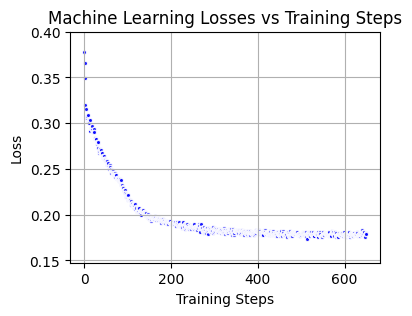

In [130]:
fig = plot_losses_vs_steps(losses, axmax=0.4)
plt.show()

In [137]:
wrapped_vf = WrappedModel(ball_model)
n_test = 20000
x_init = ball_noise.sample(n_test)
solver = RiemannianODESolver(velocity_model=wrapped_vf, manifold=manifold)  # create an ODESolver class

In [142]:
t_sample_start = time.time()
sol, log_det = riem_sample_and_div(
    riem_solver=solver,
    xt_batch_size=5000,
    x_init=x_init,
    step_size=0.05,
    method= "midpoint",
    return_intermediates=False,
    return_div=True,
    exact_divergence=True,
)
t_sample_elapsed = time.time() - t_sample_start


In [143]:
t_only_sample_start = time.time()
_ = solver.sample(
    x_init=x_init,
    step_size=0.05,
    method= "midpoint",
    return_intermediates=False,
    exact_divergence=True,
)
t_only_sample_elapsed = time.time() - t_only_sample_start


In [145]:
soll = sol.to(device='cpu', dtype=torch.double)

ball_flow_rounded, J_rb = map_ball_2_rounded(psm, ball=soll, alpha_root=alpha_root, sep_radius=False, jacobian=True)

log_abs_dets_J = torch.log(abs(fcm._la.det(J_rb)))  # log abs det of Jacobian from ball to rounded
log_q0 = ball_noise.log_prob(x_init).to('cpu')
log_q = log_q0 - log_det.to('cpu') - log_abs_dets_J 


In [146]:
# uncomment to check that the jacobian is indeed correct.
# from torch.autograd.functional import jacobian
# f = lambda x: map_ball_2_rounded(psm, x, sep_radius=False, jacobian=False)
# jacobian(f, soll[0])
# J_rb[0]

In [147]:
log_p = mog_target.log_prob(ball_flow_rounded.to(device='cpu'))

diff = log_p - log_q
ws = torch.exp(diff)
KL_Z = ws.mean()
ln_KL = (log_p + log_q).mean() + np.log(KL_Z)
KL = np.exp(ln_KL)
ESS = ws.sum()**2 / (ws**2).sum()
print(f'ESS: {round(ESS.item() / n_test, 3)}, KL div.: {KL:.3e}, in pol: {0},' \
    f'training time: {train_time_total}, sampling time: {t_sample_elapsed}, only sample time {t_only_sample_elapsed}')

ESS: 0.634, KL div.: 8.428e-01, in pol: 0,training time: 247.3304512500763, sampling time: 32.662413597106934, only sample time 1.3666741847991943


In [140]:
plt.ioff()

fig, ax = plot_dataframes(
    vertices=v_representation,
    samples=pd.DataFrame(ball_flow_rounded, columns=fcm.sampler.rounded_id),
    n_sample_cdf=10000,
    points=means_df,
    x_col='R_h_out', 
    y_col='R_biomass',
    x_label='R_h_out', 
    y_label='R_biomass',
    label1='Polytope', 
    label2='Samples Convex Hull',
    label3='Samples KDE Density', 
    label4='Additional Points',
    bw_method=None,
    bw_adjust=0.6,
    levels=8,
    font_dict=None,
    vertices_fill_color='#ffec58',
    samples_fill_color='#e02450',
    figsize=(6, 4),
    show_legend=False,
    legend_loc='best',
    s_points=15,
    points_color='#C41E3A',
)
# plt.show()

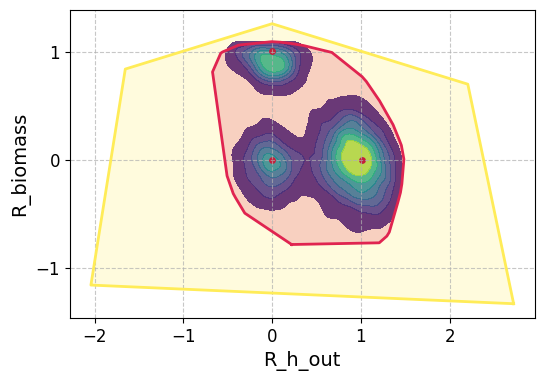

In [141]:
plt.show()

In [114]:
plt.savefig(
    'ball_flow.svg', transparent=None, dpi='figure', format='svg',
    metadata=None, bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto', backend=None,
)